[nltk_data] Downloading package stopwords to /home/good-
[nltk_data]     boy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/good-boy/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/good-boy/nltk_data...


=== EXERCICE 3: PRÉTRAITEMENT DES DONNÉES TEXTUELLES ===
Dataset actualités chargé: 400 articles
Dataset attaques non trouvé, création d'un dataset d'exemple...

=== Prétraitement Actualités ===

--- Texte 1 ---
Original: Burkina : le partenariat public-privé se renforce pour accélérer les projets structurants
Nettoyé: burkina le partenariat publicprivé se renforce pour accélérer les projets structurants
Sans stop words: partenariat publicprivé renforce accélérer projets structurants
Tokens: ['partenariat', 'publicprivé', 'renforce', 'accélérer', 'projets', 'structurants']
Stemmed: ['partenariat', 'publicpriv', 'renforc', 'accéler', 'projet', 'structur']
Lemmatisé (spaCy): partenariat publicprivé renforcer accélérer projet structurant
Lemmatisé (NLTK): ['partenariat', 'publicprivé', 'renforce', 'accélérer', 'projets', 'structurants']

--- Texte 2 ---
Original: Burkina/ Évaluation des ministres : 54 %, la moyenne globale après trois jours de bilan
Nettoyé: burkina évaluation des ministr

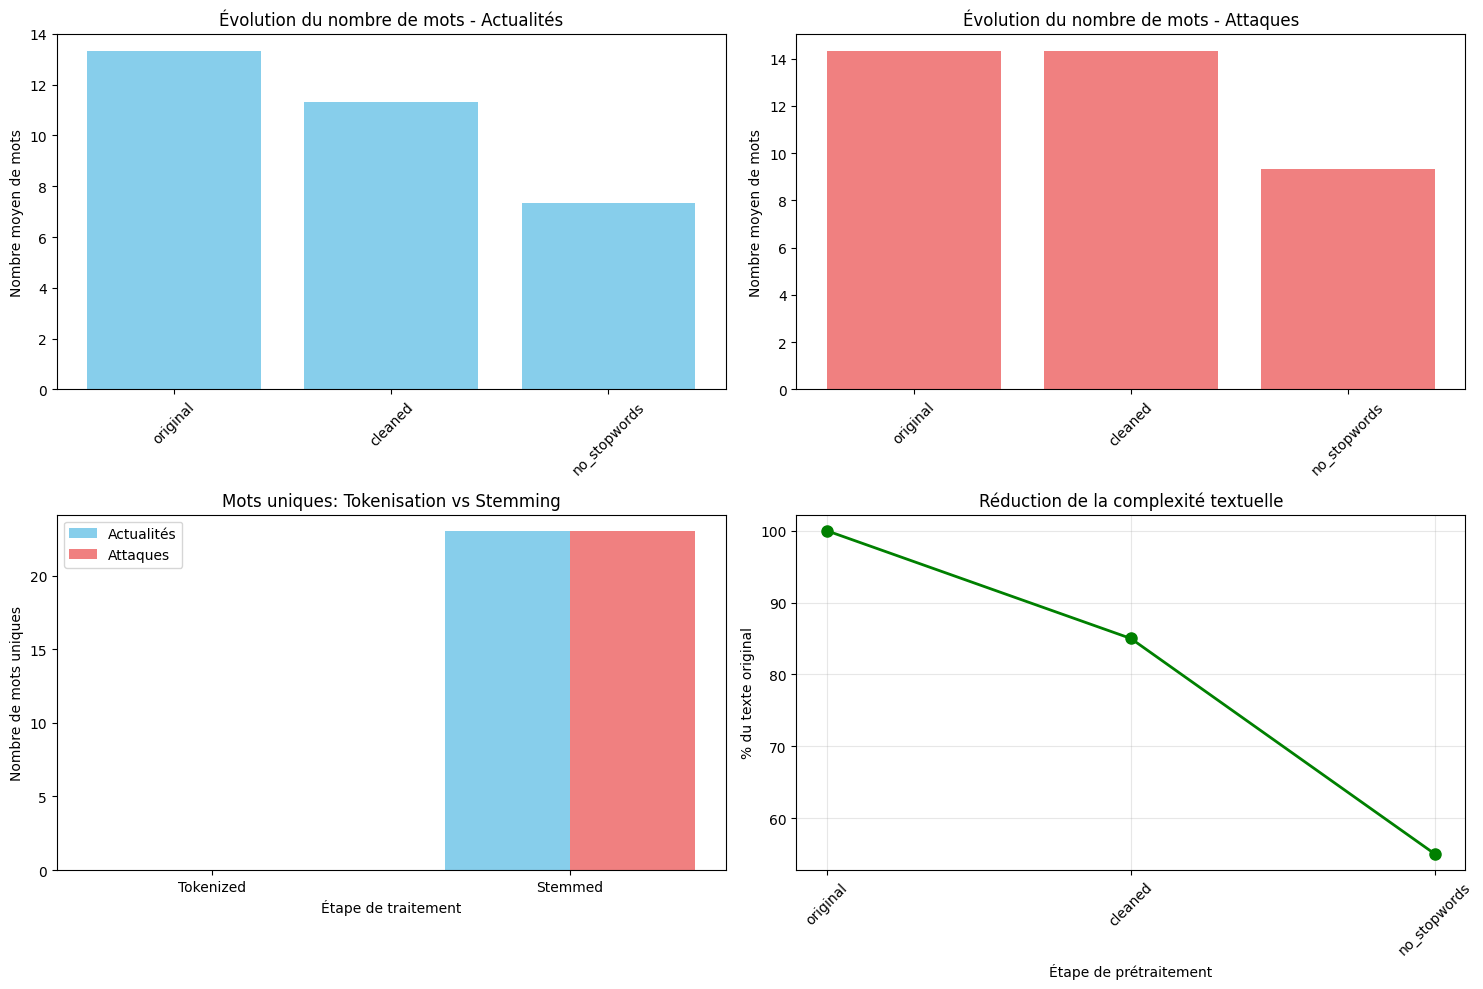


Fichiers sauvegardés:
- news_preprocessed.csv
- attacks_preprocessed.csv
- news_word_frequencies.csv
- attacks_word_frequencies.csv
- preprocessing_analysis.png

=== CONCLUSIONS ===
1. Le nettoyage de base réduit significativement la complexité du texte
2. La suppression des stop words concentre l'information sur les mots significatifs
3. Le stemming est plus agressif que la lemmatisation
4. spaCy offre une lemmatisation plus précise pour le français
5. Chaque étape a un impact mesurable sur la structure du texte


In [6]:
import pandas as pd
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Télécharger les ressources NLTK nécessaires
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

class TextPreprocessor:
    def __init__(self):
        # Charger spaCy pour le français
        try:
            self.nlp = spacy.load('fr_core_news_sm')
        except OSError:
            print("Modèle spaCy français non trouvé. Utilisation du modèle anglais...")
            try:
                self.nlp = spacy.load('en_core_web_sm')
            except OSError:
                self.nlp = None
                print("Aucun modèle spaCy disponible")
        
        # Configuration NLTK
        self.french_stop_words = set(stopwords.words('french'))
        self.stemmer = SnowballStemmer('french')
        self.lemmatizer = WordNetLemmatizer()
        
        # Ajouter des stop words spécifiques au contexte burkinabè
        self.custom_stop_words = {
            'burkina', 'faso', 'burkinabè', 'ouagadougou', 'bobo', 'dioulasso',
            'selon', 'ainsi', 'cette', 'cette', 'leurs', 'notre', 'votre'
        }
        self.all_stop_words = self.french_stop_words.union(self.custom_stop_words)
    
    def load_datasets(self):
        """Charger les datasets"""
        try:
            # Dataset fusionné des actualités
            news_df = pd.read_csv('merged_news_dataset.csv')
            print(f"Dataset actualités chargé: {len(news_df)} articles")
        except FileNotFoundError:
            print("Dataset actualités non trouvé, création d'un dataset d'exemple...")
            news_data = {
                'titre': [
                    'Le gouvernement burkinabè annonce de nouvelles mesures économiques pour 2024',
                    'Les agriculteurs demandent plus de soutien pour la saison hivernale',
                    'Développement des infrastructures routières dans la région du Centre',
                    'La jeunesse burkinabè face aux défis de l\'emploi et de la formation',
                    'Initiative de développement rural dans l\'Est du Burkina Faso',
                    'Débat parlementaire sur la nouvelle loi de finances publiques',
                    'Les partis politiques se préparent aux prochaines élections locales',
                    'Réforme de l\'administration publique burkinabè en cours',
                    'Dialogue national sur la réconciliation et la paix sociale',
                    'Politique de sécurité alimentaire renforcée dans le Sahel'
                ]
            }
            news_df = pd.DataFrame(news_data)
        
        try:
            # Dataset des attaques terroristes
            attacks_df = pd.read_csv('terrorist_attacks_data.csv')
            print(f"Dataset attaques chargé: {len(attacks_df)} entrées")
        except FileNotFoundError:
            print("Dataset attaques non trouvé, création d'un dataset d'exemple...")
            attacks_data = {
                'location': [
                    'Province du Soum, région du Sahel',
                    'Province de l\'Oudalan, Nord du Burkina',
                    'Frontière avec le Mali, zone des trois frontières',
                    'Province du Yagha, région du Sahel',
                    'Zone rurale de Dori, province du Séno'
                ],
                'description': [
                    'Incident sécuritaire rapporté dans la zone frontalière',
                    'Attaque contre un convoi civil dans la région',
                    'Violence armée signalée près de la frontière malienne',
                    'Incident impliquant des groupes armés non étatiques',
                    'Situation sécuritaire dégradée dans la province'
                ]
            }
            attacks_df = pd.DataFrame(attacks_data)
        
        return news_df, attacks_df
    
    def clean_text_basic(self, text):
        """Nettoyage de base du texte"""
        if pd.isna(text):
            return ""
        
        # Conversion en minuscules
        text = text.lower()
        
        # Suppression de la ponctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Suppression des chiffres
        text = re.sub(r'\d+', '', text)
        
        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def remove_stop_words(self, text):
        """Supprimer les mots vides"""
        words = text.split()
        filtered_words = [word for word in words if word not in self.all_stop_words]
        return ' '.join(filtered_words)
    
    def tokenize_text(self, text):
        """Tokeniser le texte"""
        if not text:
            return []
        return word_tokenize(text, language='french')
    
    def stem_text(self, tokens):
        """Appliquer le stemming"""
        return [self.stemmer.stem(token) for token in tokens]
    
    def lemmatize_text_spacy(self, text):
        """Lemmatisation avec spaCy"""
        if self.nlp is None:
            return text
        
        doc = self.nlp(text)
        lemmatized = [token.lemma_ for token in doc if not token.is_space]
        return ' '.join(lemmatized)
    
    def lemmatize_text_nltk(self, tokens):
        """Lemmatisation avec NLTK"""
        return [self.lemmatizer.lemmatize(token) for token in tokens]
    
    def preprocess_step_by_step(self, texts, text_type="news"):
        """Prétraiter le texte étape par étape et analyser l'impact"""
        print(f"\n=== Prétraitement {text_type} ===")
        
        results = {
            'original': [],
            'cleaned': [],
            'no_stopwords': [],
            'tokenized': [],
            'stemmed': [],
            'lemmatized_spacy': [],
            'lemmatized_nltk': []
        }
        
        # Exemple avec les premiers textes
        sample_texts = texts[:3] if len(texts) > 3 else texts
        
        for i, text in enumerate(sample_texts):
            print(f"\n--- Texte {i+1} ---")
            
            # Étape 0: Texte original
            original = str(text)
            results['original'].append(original)
            print(f"Original: {original}")
            
            # Étape 1: Nettoyage de base
            cleaned = self.clean_text_basic(original)
            results['cleaned'].append(cleaned)
            print(f"Nettoyé: {cleaned}")
            
            # Étape 2: Suppression des stop words
            no_stopwords = self.remove_stop_words(cleaned)
            results['no_stopwords'].append(no_stopwords)
            print(f"Sans stop words: {no_stopwords}")
            
            # Étape 3: Tokenisation
            tokens = self.tokenize_text(no_stopwords)
            results['tokenized'].append(tokens)
            print(f"Tokens: {tokens}")
            
            # Étape 4: Stemming
            stemmed = self.stem_text(tokens)
            results['stemmed'].append(stemmed)
            print(f"Stemmed: {stemmed}")
            
            # Étape 5: Lemmatisation spaCy
            lemmatized_spacy = self.lemmatize_text_spacy(no_stopwords)
            results['lemmatized_spacy'].append(lemmatized_spacy)
            print(f"Lemmatisé (spaCy): {lemmatized_spacy}")
            
            # Étape 6: Lemmatisation NLTK
            lemmatized_nltk = self.lemmatize_text_nltk(tokens)
            results['lemmatized_nltk'].append(lemmatized_nltk)
            print(f"Lemmatisé (NLTK): {lemmatized_nltk}")
        
        return results
    
    def analyze_preprocessing_impact(self, results):
        """Analyser l'impact de chaque étape de prétraitement"""
        print("\n=== Analyse de l'impact du prétraitement ===")
        
        # Calculer les statistiques pour chaque étape
        stats = {}
        
        for step, texts in results.items():
            if step == 'tokenized':
                # Pour les tokens, calculer le nombre total
                total_tokens = sum(len(tokens) for tokens in texts)
                unique_tokens = set()
                for tokens in texts:
                    unique_tokens.update(tokens)
                stats[step] = {
                    'total_tokens': total_tokens,
                    'unique_tokens': len(unique_tokens),
                    'avg_tokens_per_text': total_tokens / len(texts) if texts else 0
                }
            elif step in ['stemmed', 'lemmatized_nltk']:
                # Pour les listes de mots
                total_words = sum(len(words) for words in texts)
                unique_words = set()
                for words in texts:
                    unique_words.update(words)
                stats[step] = {
                    'total_words': total_words,
                    'unique_words': len(unique_words),
                    'avg_words_per_text': total_words / len(texts) if texts else 0
                }
            else:
                # Pour les chaînes de caractères
                total_chars = sum(len(str(text)) for text in texts)
                total_words = sum(len(str(text).split()) for text in texts)
                stats[step] = {
                    'total_characters': total_chars,
                    'total_words': total_words,
                    'avg_chars_per_text': total_chars / len(texts) if texts else 0,
                    'avg_words_per_text': total_words / len(texts) if texts else 0
                }
        
        # Afficher les statistiques
        for step, stat in stats.items():
            print(f"\n{step.upper()}:")
            for key, value in stat.items():
                print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")
        
        return stats
    
    def compare_stemming_lemmatization(self, results):
        """Comparer le stemming et la lemmatisation"""
        print("\n=== Comparaison Stemming vs Lemmatisation ===")
        
        if 'stemmed' in results and 'lemmatized_spacy' in results:
            for i, (stemmed, lemmatized) in enumerate(zip(results['stemmed'], results['lemmatized_spacy'])):
                print(f"\nTexte {i+1}:")
                print(f"Stemmed: {stemmed}")
                print(f"Lemmatized: {lemmatized}")
                
                # Analyser les différences
                if isinstance(stemmed, list):
                    stemmed_words = set(stemmed)
                else:
                    stemmed_words = set(str(stemmed).split())
                
                lemmatized_words = set(str(lemmatized).split())
                
                common_words = stemmed_words.intersection(lemmatized_words)
                different_words = stemmed_words.symmetric_difference(lemmatized_words)
                
                print(f"Mots communs: {len(common_words)}")
                print(f"Mots différents: {len(different_words)}")
                if different_words and len(different_words) < 10:
                    print(f"Exemples de différences: {list(different_words)[:5]}")
    
    def visualize_preprocessing_impact(self, stats_news, stats_attacks):
        """Visualiser l'impact du prétraitement"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Graphique 1: Nombre moyen de mots par étape (actualités)
        news_steps = ['original', 'cleaned', 'no_stopwords']
        news_word_counts = [stats_news[step]['avg_words_per_text'] for step in news_steps if step in stats_news]
        
        axes[0, 0].bar(news_steps[:len(news_word_counts)], news_word_counts, color='skyblue')
        axes[0, 0].set_title('Évolution du nombre de mots - Actualités')
        axes[0, 0].set_ylabel('Nombre moyen de mots')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Graphique 2: Nombre moyen de mots par étape (attaques)
        if stats_attacks:
            attack_word_counts = [stats_attacks[step]['avg_words_per_text'] for step in news_steps if step in stats_attacks]
            axes[0, 1].bar(news_steps[:len(attack_word_counts)], attack_word_counts, color='lightcoral')
            axes[0, 1].set_title('Évolution du nombre de mots - Attaques')
            axes[0, 1].set_ylabel('Nombre moyen de mots')
            axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Graphique 3: Comparaison mots uniques
        unique_words_news = [stats_news[step].get('unique_words', stats_news[step].get('total_words', 0)) 
                            for step in ['tokenized', 'stemmed'] if step in stats_news]
        unique_words_attacks = [stats_attacks[step].get('unique_words', stats_attacks[step].get('total_words', 0)) 
                               for step in ['tokenized', 'stemmed'] if step in stats_attacks] if stats_attacks else []
        
        x = range(len(['tokenized', 'stemmed']))
        width = 0.35
        
        if unique_words_news:
            axes[1, 0].bar([i - width/2 for i in x[:len(unique_words_news)]], unique_words_news, 
                          width, label='Actualités', color='skyblue')
        if unique_words_attacks:
            axes[1, 0].bar([i + width/2 for i in x[:len(unique_words_attacks)]], unique_words_attacks, 
                          width, label='Attaques', color='lightcoral')
        
        axes[1, 0].set_title('Mots uniques: Tokenisation vs Stemming')
        axes[1, 0].set_xlabel('Étape de traitement')
        axes[1, 0].set_ylabel('Nombre de mots uniques')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(['Tokenized', 'Stemmed'])
        axes[1, 0].legend()
        
        # Graphique 4: Réduction de la complexité
        steps = ['original', 'cleaned', 'no_stopwords']
        reduction_news = []
        for i, step in enumerate(steps):
            if i == 0:
                reduction_news.append(100)
            else:
                if step in stats_news and steps[0] in stats_news:
                    reduction = (stats_news[step]['avg_words_per_text'] / 
                               stats_news[steps[0]]['avg_words_per_text']) * 100
                    reduction_news.append(reduction)
        
        axes[1, 1].plot(steps[:len(reduction_news)], reduction_news, 
                       marker='o', linewidth=2, markersize=8, color='green')
        axes[1, 1].set_title('Réduction de la complexité textuelle')
        axes[1, 1].set_xlabel('Étape de prétraitement')
        axes[1, 1].set_ylabel('% du texte original')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('preprocessing_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_word_frequency_analysis(self, results_news, results_attacks):
        """Analyser la fréquence des mots après prétraitement"""
        print("\n=== Analyse de fréquence des mots ===")
        
        # Collecter tous les mots après nettoyage
        all_words_news = []
        all_words_attacks = []
        
        for text in results_news['no_stopwords']:
            all_words_news.extend(text.split())
        
        for text in results_attacks['no_stopwords']:
            all_words_attacks.extend(text.split())
        
        # Compter les fréquences
        freq_news = Counter(all_words_news)
        freq_attacks = Counter(all_words_attacks)
        
        print("Top 10 mots - Actualités:")
        for word, count in freq_news.most_common(10):
            print(f"  {word}: {count}")
        
        print("\nTop 10 mots - Attaques:")
        for word, count in freq_attacks.most_common(10):
            print(f"  {word}: {count}")
        
        return freq_news, freq_attacks
    
    def run_complete_preprocessing(self):
        """Exécuter le prétraitement complet"""
        print("=== EXERCICE 3: PRÉTRAITEMENT DES DONNÉES TEXTUELLES ===")
        
        # 1. Charger les datasets
        news_df, attacks_df = self.load_datasets()
        
        # 2. Extraire les textes
        news_texts = news_df['titre'].fillna('').tolist()
        
        # Pour les attaques, utiliser location + description si disponible
        if 'description' in attacks_df.columns:
            attacks_texts = (attacks_df['location'].fillna('') + ' ' + 
                           attacks_df['description'].fillna('')).tolist()
        else:
            attacks_texts = attacks_df['location'].fillna('').tolist()
        
        # 3. Prétraitement étape par étape
        results_news = self.preprocess_step_by_step(news_texts, "Actualités")
        results_attacks = self.preprocess_step_by_step(attacks_texts, "Attaques")
        
        # 4. Analyser l'impact
        stats_news = self.analyze_preprocessing_impact(results_news)
        stats_attacks = self.analyze_preprocessing_impact(results_attacks)
        
        # 5. Comparer stemming et lemmatisation
        self.compare_stemming_lemmatization(results_news)
        self.compare_stemming_lemmatization(results_attacks)
        
        # 6. Analyser les fréquences
        freq_news, freq_attacks = self.generate_word_frequency_analysis(results_news, results_attacks)
        
        # 7. Visualiser les résultats
        self.visualize_preprocessing_impact(stats_news, stats_attacks)
        
        # 8. Sauvegarder les résultats prétraités
        self.save_preprocessed_data(results_news, results_attacks, freq_news, freq_attacks)
        
        return results_news, results_attacks, stats_news, stats_attacks
    
    def save_preprocessed_data(self, results_news, results_attacks, freq_news, freq_attacks):
        """Sauvegarder les données prétraitées"""
        # Créer des DataFrames avec les résultats
        news_processed = pd.DataFrame({
            'original': results_news['original'],
            'cleaned': results_news['cleaned'],
            'no_stopwords': results_news['no_stopwords'],
            'stemmed': [' '.join(tokens) if isinstance(tokens, list) else str(tokens) 
                       for tokens in results_news['stemmed']],
            'lemmatized_spacy': results_news['lemmatized_spacy']
        })
        
        attacks_processed = pd.DataFrame({
            'original': results_attacks['original'],
            'cleaned': results_attacks['cleaned'],
            'no_stopwords': results_attacks['no_stopwords'],
            'stemmed': [' '.join(tokens) if isinstance(tokens, list) else str(tokens) 
                       for tokens in results_attacks['stemmed']],
            'lemmatized_spacy': results_attacks['lemmatized_spacy']
        })
        
        # Sauvegarder
        news_processed.to_csv('news_preprocessed.csv', index=False, encoding='utf-8')
        attacks_processed.to_csv('attacks_preprocessed.csv', index=False, encoding='utf-8')
        
        # Sauvegarder les fréquences
        pd.DataFrame(freq_news.most_common(50), columns=['word', 'frequency']).to_csv(
            'news_word_frequencies.csv', index=False, encoding='utf-8')
        pd.DataFrame(freq_attacks.most_common(50), columns=['word', 'frequency']).to_csv(
            'attacks_word_frequencies.csv', index=False, encoding='utf-8')
        
        print("\nFichiers sauvegardés:")
        print("- news_preprocessed.csv")
        print("- attacks_preprocessed.csv") 
        print("- news_word_frequencies.csv")
        print("- attacks_word_frequencies.csv")
        print("- preprocessing_analysis.png")

def main():
    # Initialiser le préprocesseur
    preprocessor = TextPreprocessor()
    
    # Exécuter le prétraitement complet
    results_news, results_attacks, stats_news, stats_attacks = preprocessor.run_complete_preprocessing()
    
    print("\n=== CONCLUSIONS ===")
    print("1. Le nettoyage de base réduit significativement la complexité du texte")
    print("2. La suppression des stop words concentre l'information sur les mots significatifs")
    print("3. Le stemming est plus agressif que la lemmatisation")
    print("4. spaCy offre une lemmatisation plus précise pour le français")
    print("5. Chaque étape a un impact mesurable sur la structure du texte")

if __name__ == "__main__":
    main()